In [1]:
!git clone https://github.com/jvkersch/pyconcorde

fatal: 目标路径 'pyconcorde' 已经存在，并且不是一个空目录。


In [2]:
cd pyconcorde

/input/pyconcorde


In [3]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/miniconda3/lib/python3.6/site-packages (19.3.1)


In [14]:
!pip install -e .

Obtaining file:///input/pyconcorde/pyconcorde
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/input/pyconcorde/pyconcorde/setup.py", line 33, in <module>
        from Cython.Build import cythonize
    ModuleNotFoundError: No module named 'Cython'
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /input/pyconcorde/pyconcorde/
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
!nvidia-smi

Tue Nov 26 18:22:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:06:00.0  On |                  N/A |
| 71%   15C    P8    30W / 300W |    179MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
!pip install dgl-cu100

    100% |████████████████████████████████| 19.6MB 34kB/s  eta 0:00:01
    100% |████████████████████████████████| 25.2MB 33kB/s eta 0:00:011
    100% |████████████████████████████████| 20.0MB 33kB/s  eta 0:00:01
    100% |████████████████████████████████| 1.6MB 425kB/s eta 0:00:01
You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:

from config import get_config
config = get_config("configs/default.json")


In [23]:
config

{'expt_name': 'deafult',
 'gpu_id': '0',
 'train_filepath': 'None',
 'val_filepath': 'None',
 'test_filepath': 'None',
 'train_num_samples': 5000,
 'val_num_samples': 500,
 'test_num_samples': 500,
 'num_nodes': 20,
 'num_neighbors': -1,
 'node_dim': 2,
 'voc_nodes_in': 2,
 'voc_nodes_out': 2,
 'voc_edges_in': 3,
 'voc_edges_out': 2,
 'beam_size': 1280,
 'hidden_dim': 50,
 'num_layers': 3,
 'mlp_layers': 2,
 'num_epochs': 20,
 'batch_size': 32,
 'learning_rate': 0.001,
 'decay_rate': 1.01,
 'pre_trained': 0}

In [56]:
train_set, val_set, test_set = load_dataset_for_regression(config)

ValueError: attempted relative import beyond top-level package

In [54]:
from utils.TSPDataset import TSPDataset

In [59]:
TSPDataset(num_samples = config['train_num_samples'],
            num_nodes = config['num_nodes'],
            node_dim = config['node_dim'],
            num_neighbors = config['num_neighbors'],
            file_name = None,
            load_mode = 'generate',
            set_type = 'train',
            seed = 0)

Start generating dataset...
Completed generation of 5000 samples of TSP20.
Total time: 11.0min
Average time: 0.00min


In [60]:
%run train.py

ValueError: attempted relative import beyond top-level package

# Dataset

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 24 19:06:52 2019

@author: lenovo
"""

import torch as th
import torch.nn.functional as F
import torch.nn as nn

import time
import numpy as np
import pandas as pd

import dgl
import dgl.function as fn
from dgl.data.utils import load_graphs, save_graphs

from concorde.tsp import TSPSolver

class TSPDataset(object):
    def __init__(
        self,
        num_samples = 10000,
        num_nodes = 10,
        node_dim = 2,
        num_neighbors = -1,
        file_name = None,
        load_mode = 'read',
        seed = 0
        ):
        self.num_samples = num_samples
        self.num_nodes = num_nodes
        self.node_dim = node_dim
        self.num_neighbors = num_neighbors
        if file_name == None:
            self.file_name = f"\data\tsp{num_nodes}_concorde_{num_samples}.bin"
        else:
            self.file_name = file_name
        self.load_mode = load_mode
        self.seed = seed
        self._load()
        
    def _load(self):
        if self.load_mode == 'read':
            self.graphs, tour_dict = load_graphs(self.file_name)
            self.tours = tour_dict['tsp_tours']
        else:
            print('Start generating dataset...')
            self.graphs, tour_dict = self.generate_data(
                            self.num_samples,
                            self.num_nodes,
                            self.node_dim,
                            self.num_neighbors,
                            self.file_name,
                            self.seed)
            self.tours = tour_dict['tsp_tours']
    def generate_data(
                self,
                num_samples,
                num_nodes,
                node_dim = 2,
                num_neighbors = -1,
                file_name = None,
                seed = 0
        ):
        """
        return graph dataset
        """
        np.random.seed(seed)
        set_nodes_coord = np.random.random([num_samples, num_nodes, node_dim])
        graphs, labels = [],[]
        start_time = time.time()
        for nodes_coord in set_nodes_coord:
            #compute complete graph
            g = dgl.transform.knn_graph(th.tensor(nodes_coord), num_nodes)        
            solver = TSPSolver.from_data(nodes_coord[:,0], nodes_coord[:,1], norm="GEO")  
            solution = solver.solve()
            nodes_coord = th.tensor(nodes_coord).float()
            g.ndata['coord'] = nodes_coord
            g.apply_edges(fn.u_sub_v('coord', 'coord', 'e'))
            #distance
            g.edata['e'] = th.norm(g.edata['e'], dim = 1)
            #neighbors embedding
            e_tags = th.zeros(g.number_of_edges(), 3).float()
            e_tags[:,0] = 1.
            if num_neighbors != -1:
                knn = dgl.transform.knn_graph(nodes_coord, num_neighbors)  
                #remove self loop
                knn = dgl.transform.remove_self_loop(knn) 
                src, dst = knn.edges()
                edge_nb = g.edge_ids(src, dst)
                e_tags[edge_nb, :] = th.tensor([0.,1.,0.])
                #for self loop
                self_loop_id = g.edge_ids(list(range(num_nodes)),
                                          list(range(num_nodes)))
        
                e_tags[self_loop_id, :] = th.tensor([0.,0.,1.])
            g.edata['e'] = th.cat((g.edata['e'].unsqueeze(1), e_tags), dim = 1)
            graphs.append(g)
            labels.append(solution.tour)
        graph_labels = {'tsp_tours': th.tensor(labels).long()}
        save_graphs(file_name, graphs, graph_labels)
        end_time = time.time() - start_time
        print(f"Completed generation of {num_samples} samples of TSP{num_nodes}.")
        print(f"Total time: {end_time/60:.1f}min")
        print(f"Average time: {(end_time/60)/num_samples:.2f}min")
        return graphs, graph_labels

    def __getitem__(self, item):
        g,t = self.graphs[item],self.tours[item]
        w = self.tour2w(t)
        return g, w, t
    
    def __len__(self):
        """Length of the dataset
        Returns
        -------
        int
            Length of Dataset
        """
        return len(self.graphs)

    def tour2w(self, tour):
        """
        input: num_nodes
        return: B*(V*V)
        """
        num_nodes = tour.size()[0]
        w = th.zeros(num_nodes , num_nodes)
        src, dst = tour[:-1].long(), tour[1:].long()
        w[src, dst] = 1
        w[tour[-1], tour[0]] = 1
        return w.long()
    def collate_tspgraphs(self,data):
        """
        data: list of 2-tuples, w is the flat adj matrix
        """
        graphs, w, t = map(list, zip(*data))
        bg = dgl.batch(graphs)
        ws, tours = th.stack(w, dim = 0),th.stack(t, dim = 0)
        return bg, ws, tours

# Layers

In [0]:
import torch as th
from torch import nn
import torch.nn.functional as F

import dgl
from dgl.data import CoraDataset
import dgl.function as fn
from dgl.nn.pytorch.softmax import edge_softmax

class TSPConv(nn.Module):
    def __init__(self,
                 in_feats):
        super(TSPConv, self).__init__()
        self._in_feats = in_feats
        
        self.W_list = nn.ModuleList([nn.Linear(in_feats, in_feats, bias=False) for i in range(5)])
        self.relu = nn.ReLU()
        self.edge_batch_norm = nn.BatchNorm1d(in_feats, track_running_stats=False)
        self.node_batch_norm = nn.BatchNorm1d(in_feats, track_running_stats=False)

    def forward(self, graph, n_feat, e_feat):
        graph = graph.local_var()
        for i in range(4):
            graph.ndata[f'W_{i}h'] = self.W_list[i](n_feat)  
       
        # update e_feat
        new_e = self.edge_update(graph, e_feat)
        
        # update n_feat
        new_h = self.node_update(graph, e_feat, n_feat)        
        return new_h, new_e
    
    def edge_update(self, graph, e_feat):
        W_4e =  self.W_list[4](e_feat)  
        graph.apply_edges(fn.u_add_v("W_0h", "W_1h", "e_tmp"))
        e_ = self.relu(self.edge_batch_norm(graph.edata['e_tmp'] + W_4e))
        return e_ + e_feat
    
    def node_update(self, graph, e_feat, n_feat): 
        graph.edata['a'] = edge_softmax(graph, e_feat)
        graph.update_all(fn.u_mul_e('W_3h', 'a', 'm'),
                         fn.sum('m', 'n_tmp'))
        n_ = self.relu(self.node_batch_norm(graph.ndata['n_tmp'] + graph.ndata['W_2h']))
        return n_ + n_feat

 
class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction.
    """

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        self.L = L
        U = []
        for layer in range(self.L - 1):
            U.append(nn.Linear(hidden_dim, hidden_dim, True))
        self.U = nn.ModuleList(U)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, hidden_dim)
        Returns:
            y: Output predictions (batch_size, output_dim)
        """
        Ux = x
        for U_i in self.U:
            Ux = U_i(Ux)  # B x H
            Ux = F.relu(Ux)  # B x H
        y = self.V(Ux)  # B x O
        return y

# model

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 24 18:35:37 2019

@author: lenovo
"""

import torch as th
import torch.nn as nn
import torch.nn.functional as F


class TSPModel(nn.Module):
    def __init__(self, config):
        super(TSPModel, self).__init__()
        # Define net parameters
        self.num_nodes = config['num_nodes']
        self.node_dim = config['node_dim']
        self.voc_nodes_in = config['voc_nodes_in']
        self.voc_nodes_out = config['num_nodes']  # config['voc_nodes_out']
        self.voc_edges_in = config['voc_edges_in']
        self.voc_edges_out = config['voc_edges_out']
        self.hidden_dim = config['hidden_dim']
        self.num_layers = config['num_layers']
        self.mlp_layers = config['mlp_layers']
        self.aggregation = config['aggregation']
        # Node and edge embedding layers/lookups
        self.nodes_embedding = nn.Linear(self.node_dim, self.hidden_dim, bias=False)
        self.edges_embedding = nn.Linear(1+self.voc_edges_in, self.hidden_dim, bias=False)

        gcn_layers = []
        for layer in range(self.num_layers):
            gcn_layers.append(TSPConv(self.hidden_dim))
        self.gcn_layers = nn.ModuleList(gcn_layers)
        # Define MLP classifiers
        self.mlp_edges = MLP(self.hidden_dim, 2, self.mlp_layers)

    def forward(self, graph, n_feat, e_feat):
        """
        """
        x = self.nodes_embedding(n_feat)
        e = self.edges_embedding(e_feat)
        for layer in range(self.num_layers):
            x, e = self.gcn_layers[layer](graph, x, e)  # (B x V) x H, (B x V x V) x H
        # MLP classifier
        y_pred_edges = self.mlp_edges(e)  # (B x V x V) x 2
        bs = graph.batch_size
        y_pred_edges = y_pred_edges.view(bs, self.num_nodes,self.num_nodes, 2)
        # B x V x V x H
        return y_pred_edges

def regress(model, bg):
    x = bg.ndata['coord']
    e = bg.edata['e']
    #x, e = x.cuda(), e.cuda()
    return model(bg, x, e)

# Loss

In [0]:
 
def loss_edges(y_pred_edges, y_edges, edge_cw):
    """
    Loss function for edge predictions.
    Args:
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
        edge_cw: Class weights for edges loss
    Returns:
        loss_edges: Value of loss function
    
    """
    # Edge loss
    y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
    y = y.permute(0, 3, 1, 2)  # B x voc_edges x V x V
    loss_edges = nn.NLLLoss(edge_cw)(y, y_edges)
    return loss_edges


Dataloader

In [115]:
#Load data
num_samples = 256
num_nodes = 20
num_neighbors = -1
batch_size = 32
train_filepath = None
seed = 0

tspdataset = TSPDataset(num_samples = num_samples,
                        num_nodes = num_nodes,
                        node_dim = 2,
                        num_neighbors = num_neighbors,
                        file_name = None,
                        load_mode = 'generate',
                        seed = 0)
print("Number of batches of size {}: {}".format(batch_size, len(tspdataset)//batch_size))

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=tspdataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=tspdataset.collate_tspgraphs)

Start generating dataset...
Completed generation of 256 samples of TSP20.
Total time: 0.1min
Average time: 0.00min
Number of batches of size 32: 8


In [116]:
tspdataset[0][0].edata['e'].size()


torch.Size([400, 4])

In [117]:
tsp_test = TSPDataset(num_samples = 2,
                        num_nodes = num_nodes,
                        node_dim = 2,
                        num_neighbors = num_neighbors,
                        file_name = None,
                        load_mode = 'generate',
                        seed = 0)

Start generating dataset...
Completed generation of 2 samples of TSP20.
Total time: 0.0min
Average time: 0.00min


In [0]:
test_loader = DataLoader(dataset=tsp_test ,
                          batch_size=2,
                          shuffle=True,
                          collate_fn=tspdataset.collate_tspgraphs)

# config


In [0]:
config ={
  "expt_name": "tsp10",
  "gpu_id": "0",

  "train_filepath": "./data/tsp10_train_concorde.txt",
  "val_filepath": "./data/tsp10_val_concorde.txt",
  "test_filepath": "./data/tsp10_test_concorde.txt",

  "num_nodes": 20,
  "num_neighbors": -1,

  "node_dim": 2,
  "voc_nodes_in": 2,
  "voc_nodes_out": 2,
  "voc_edges_in": 3,
  "voc_edges_out": 2,

  "beam_size": 1280,

  "hidden_dim": 100,
  "num_layers": 30,
  "mlp_layers": 3,
  "aggregation": "mean",

  "max_epochs": 1500,
  "val_every": 5,
  "test_every": 100,

  "batch_size": 20,
  "batches_per_epoch": 500,
  "accumulation_steps": 1,

  "learning_rate": 0.001,
  "decay_rate": 1.01
}

In [0]:
net = TSPModel(config)

In [153]:
net

TSPModel(
  (nodes_embedding): Linear(in_features=2, out_features=100, bias=False)
  (edges_embedding): Linear(in_features=4, out_features=100, bias=False)
  (gcn_layers): ModuleList(
    (0): TSPConv(
      (W_list): ModuleList(
        (0): Linear(in_features=100, out_features=100, bias=False)
        (1): Linear(in_features=100, out_features=100, bias=False)
        (2): Linear(in_features=100, out_features=100, bias=False)
        (3): Linear(in_features=100, out_features=100, bias=False)
        (4): Linear(in_features=100, out_features=100, bias=False)
      )
      (relu): ReLU()
      (edge_batch_norm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (node_batch_norm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): TSPConv(
      (W_list): ModuleList(
        (0): Linear(in_features=100, out_features=100, bias=False)
        (1): Linear(in_features=100, out_features=100, bias=False)
      

In [0]:
optimizer = th.optim.Adam(net.parameters(),0.01)

In [155]:
#net.cuda()
net.train()
for epoch in range(20):
    epoch_loss = 0
    i = 1
    for batch_id, batch_data in enumerate(train_loader):
        bg, ws, tours = batch_data
        #ws, tours = ws.cuda(), tours.cuda()
        prediction = regress(net, bg)
        loss = loss_edges(prediction, ws.long(), None)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #train_meter.update(prediction, labels, masks)
        epoch_loss+=loss.item()
        i+=1
    print('epoch {:d}/{:d}: {:.4f}'.format(
                    epoch+1,20 ,epoch_loss/i))

epoch 1/20: 0.6948
epoch 2/20: 0.3295
epoch 3/20: 0.1625
epoch 4/20: 0.1387
epoch 5/20: 0.1326
epoch 6/20: 0.1275
epoch 7/20: 0.1234
epoch 8/20: 0.1205
epoch 9/20: 0.1178
epoch 10/20: 0.1151
epoch 11/20: 0.1130
epoch 12/20: 0.1109
epoch 13/20: 0.1120
epoch 14/20: 0.1136
epoch 15/20: 0.1111
epoch 16/20: 0.1086
epoch 17/20: 0.1069
epoch 18/20: 0.1070
epoch 19/20: 0.1062
epoch 20/20: 0.1057


In [0]:
import numpy as np
import torch


class Beamsearch(object):
    """Class for managing internals of beamsearch procedure.
    References:
        General: https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/beam.py
        For TSP: https://github.com/alexnowakvila/QAP_pt/blob/master/src/tsp/beam_search.py
    """

    def __init__(self, beam_size, batch_size, num_nodes,
                 dtypeFloat=torch.FloatTensor, dtypeLong=torch.LongTensor, 
                 probs_type='raw', random_start=False):
        """
        Args:
            beam_size: Beam size
            batch_size: Batch size
            num_nodes: Number of nodes in TSP tours
            dtypeFloat: Float data type (for GPU/CPU compatibility)
            dtypeLong: Long data type (for GPU/CPU compatibility)
            probs_type: Type of probability values being handled by beamsearch (either 'raw'/'logits'/'argmax'(TODO))
            random_start: Flag for using fixed (at node 0) vs. random starting points for beamsearch
        """
        # Beamsearch parameters
        self.batch_size = batch_size
        self.beam_size = beam_size
        self.num_nodes = num_nodes
        self.probs_type = probs_type
        # Set data types
        self.dtypeFloat = dtypeFloat
        self.dtypeLong = dtypeLong
        # Set beamsearch starting nodes
        self.start_nodes = torch.zeros(batch_size, beam_size).type(self.dtypeLong)
        if random_start == True:
            # Random starting nodes
            self.start_nodes = torch.randint(0, num_nodes, (batch_size, beam_size)).type(self.dtypeLong)
        # Mask for constructing valid hypothesis
        self.mask = torch.ones(batch_size, beam_size, num_nodes).type(self.dtypeFloat)
        self.update_mask(self.start_nodes)  # Mask the starting node of the beam search
        # Score for each translation on the beam
        self.scores = torch.zeros(batch_size, beam_size).type(self.dtypeFloat)
        self.all_scores = []
        # Backpointers at each time-step
        self.prev_Ks = []
        # Outputs at each time-step
        self.next_nodes = [self.start_nodes]

    def get_current_state(self):
        """Get the output of the beam at the current timestep.
        """
        current_state = (self.next_nodes[-1].unsqueeze(2)
                         .expand(self.batch_size, self.beam_size, self.num_nodes))
        return current_state

    def get_current_origin(self):
        """Get the backpointers for the current timestep.
        """
        return self.prev_Ks[-1]

    def advance(self, trans_probs):
        """Advances the beam based on transition probabilities.
        Args:
            trans_probs: Probabilities of advancing from the previous step (batch_size, beam_size, num_nodes)
        """
        # Compound the previous scores (summing logits == multiplying probabilities)
        if len(self.prev_Ks) > 0:
            if self.probs_type == 'raw':
                beam_lk = trans_probs * self.scores.unsqueeze(2).expand_as(trans_probs)
            elif self.probs_type == 'logits':
                beam_lk = trans_probs + self.scores.unsqueeze(2).expand_as(trans_probs)
        else:
            beam_lk = trans_probs
            # Only use the starting nodes from the beam
            if self.probs_type == 'raw':
                beam_lk[:, 1:] = torch.zeros(beam_lk[:, 1:].size()).type(self.dtypeFloat)
            elif self.probs_type == 'logits':
                beam_lk[:, 1:] = -1e20 * torch.ones(beam_lk[:, 1:].size()).type(self.dtypeFloat)
        # Multiply by mask
        beam_lk = beam_lk * self.mask
        beam_lk = beam_lk.view(self.batch_size, -1)  # (batch_size, beam_size * num_nodes)
        # Get top k scores and indexes (k = beam_size)
        bestScores, bestScoresId = beam_lk.topk(self.beam_size, 1, True, True)
        # Update scores
        self.scores = bestScores
        # Update backpointers
        prev_k = bestScoresId / self.num_nodes
        self.prev_Ks.append(prev_k)
        # Update outputs
        new_nodes = bestScoresId - prev_k * self.num_nodes
        self.next_nodes.append(new_nodes)
        # Re-index mask
        perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)  # (batch_size, beam_size, num_nodes)
        self.mask = self.mask.gather(1, perm_mask)
        # Mask newly added nodes
        self.update_mask(new_nodes)

    def update_mask(self, new_nodes):
        """Sets new_nodes to zero in mask.
        """
        arr = (torch.arange(0, self.num_nodes).unsqueeze(0).unsqueeze(1)
               .expand_as(self.mask).type(self.dtypeLong))
        new_nodes = new_nodes.unsqueeze(2).expand_as(self.mask)
        update_mask = 1 - torch.eq(arr, new_nodes).type(self.dtypeFloat)
        self.mask = self.mask * update_mask
        if self.probs_type == 'logits':
            # Convert 0s in mask to inf
            self.mask[self.mask == 0] = 1e20

    def sort_best(self):
        """Sort the beam.
        """
        return torch.sort(self.scores, 0, True)

    def get_best(self):
        """Get the score and index of the best hypothesis in the beam.
        """
        scores, ids = self.sort_best()
        return scores[1], ids[1]

    def get_hypothesis(self, k):
        """Walk back to construct the full hypothesis.
        Args:
            k: Position in the beam to construct (usually 0s for most probable hypothesis)
        """
        assert self.num_nodes == len(self.prev_Ks) + 1

        hyp = -1 * torch.ones(self.batch_size, self.num_nodes).type(self.dtypeLong)
        for j in range(len(self.prev_Ks) - 1, -2, -1):
            hyp[:, j + 1] = self.next_nodes[j + 1].gather(1, k).view(1, self.batch_size)
            k = self.prev_Ks[j].gather(1, k)
        return hyp

In [0]:
def beamsearch_tour_nodes_shortest(y_pred_edges, x_edges_values, beam_size, batch_size, num_nodes,
                                   dtypeFloat, dtypeLong, probs_type='raw', random_start=False):
    """
    Performs beamsearch procedure on edge prediction matrices and returns possible TSP tours.
    Final predicted tour is the one with the shortest tour length.
    (Standard beamsearch returns the one with the highest probability and does not take length into account.)
    Args:
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
        beam_size: Beam size
        batch_size: Batch size
        num_nodes: Number of nodes in TSP tours
        dtypeFloat: Float data type (for GPU/CPU compatibility)
        dtypeLong: Long data type (for GPU/CPU compatibility)
        probs_type: Type of probability values being handled by beamsearch (either 'raw'/'logits'/'argmax'(TODO))
        random_start: Flag for using fixed (at node 0) vs. random starting points for beamsearch
    Returns:
        shortest_tours: TSP tours in terms of node ordering (batch_size, num_nodes)
    """
    if probs_type == 'raw':
        # Compute softmax over edge prediction matrix
        y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        # Consider the second dimension only
        y = y[:, :, :, 1]  # B x V x V
    elif probs_type == 'logits':
        # Compute logits over edge prediction matrix
        y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        # Consider the second dimension only
        y = y[:, :, :, 1]  # B x V x V
        y[y == 0] = -1e-20  # Set 0s (i.e. log(1)s) to very small negative number
    # Perform beamsearch
    beamsearch = Beamsearch(beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type, random_start)
    trans_probs = y.gather(1, beamsearch.get_current_state())
    for step in range(num_nodes - 1):
        beamsearch.advance(trans_probs)
        trans_probs = y.gather(1, beamsearch.get_current_state())
    # Initially assign shortest_tours as most probable tours i.e. standard beamsearch
    ends = torch.zeros(batch_size, 1).type(dtypeLong)
    shortest_tours = beamsearch.get_hypothesis(ends)
    # Compute current tour lengths
    shortest_lens = [1e6] * len(shortest_tours)
    for idx in range(len(shortest_tours)):
        shortest_lens[idx] = tour_nodes_to_tour_len(shortest_tours[idx].cpu().numpy(),
                                                    x_edges_values[idx].cpu().numpy())
    # Iterate over all positions in beam (except position 0 --> highest probability)
    for pos in range(1, beam_size):
        ends = pos * torch.ones(batch_size, 1).type(dtypeLong)  # New positions
        hyp_tours = beamsearch.get_hypothesis(ends)
        for idx in range(len(hyp_tours)):
            hyp_nodes = hyp_tours[idx].cpu().numpy()
            hyp_len = tour_nodes_to_tour_len(hyp_nodes, x_edges_values[idx].cpu().numpy())
            # Replace tour in shortest_tours if new length is shorter than current best
            if hyp_len < shortest_lens[idx] and is_valid_tour(hyp_nodes, num_nodes):
                shortest_tours[idx] = hyp_tours[idx]
                shortest_lens[idx] = hyp_len
    return shortest_tours


In [158]:
prediction.size()

torch.Size([32, 20, 20, 2])

In [159]:
bg

DGLGraph(num_nodes=640, num_edges=12800,
         ndata_schemes={'coord': Scheme(shape=(2,), dtype=torch.float32)}
         edata_schemes={'e': Scheme(shape=(4,), dtype=torch.float32)})

In [0]:
#net.cuda()
net.eval()
for epoch in range(20):
    epoch_loss = 0
    i = 1
    with th.no_grad():
        for batch_id, batch_data in enumerate(test_loader):
            bg, ws, tours = batch_data
            #ws, tours = ws.cuda(), tours.cuda()
            prediction = regress(net, bg)

In [0]:
x_edges_values = bg.edata['e'][:,0].view(2,20,20)

In [169]:
bg.edata['e'][0,:]

tensor([0., 1., 0., 0.])

In [0]:
def tour_nodes_to_tour_len(nodes, W_values):
    """Helper function to calculate tour length from ordered list of tour nodes.
    """
    tour_len = 0
    for idx in range(len(nodes) - 1):
        i = nodes[idx]
        j = nodes[idx + 1]
        tour_len += W_values[i][j]
    # Add final connection of tour in edge target
    tour_len += W_values[j][nodes[0]]
    return tour_len

In [0]:
bs_nodes = beamsearch_tour_nodes_shortest(prediction, x_edges_values, 1, 2, 20,
                                   th.float32 , th.long, probs_type='raw', random_start=False)

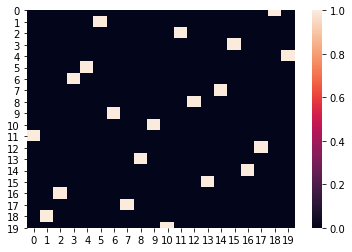

In [146]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

sns.heatmap(ws[0].detach().cpu().numpy())
plt.show()

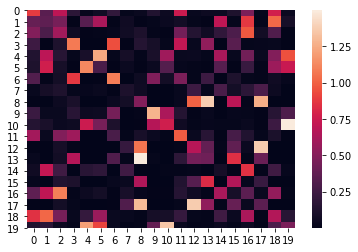

In [147]:
ax = sns.heatmap(th.exp(prediction[0][:,:,1]).detach().cpu().numpy())
plt.show()

In [0]:
def tour_nodes_to_W(nodes):
    """Helper function to convert ordered list of tour nodes to edge adjacency matrix.
    """
    W = np.zeros((len(nodes), len(nodes)))
    for idx in range(len(nodes) - 1):
        i = int(nodes[idx])
        j = int(nodes[idx + 1])
        W[i][j] = 1
        W[j][i] = 1
    # Add final connection of tour in edge target
    W[j][int(nodes[0])] = 1
    W[int(nodes[0])][j] = 1
    return W

def W_to_tour_len(W, W_values):
    """Helper function to calculate tour length from edge adjacency matrix.
    """
    tour_len = 0
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if W[i][j] == 1:
                tour_len += W_values[i][j]
    tour_len /= 2  # Divide by 2 because adjacency matrices are symmetric
    return tour_len

def plot_tsp_heatmap(p, x_coord, W_val, W_pred, title="default"):
    """
    Helper function to plot predicted TSP tours with edge strength denoting confidence of prediction.
    
    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W_val: Edge values (distance) matrix
        W_pred: Edge predictions matrix
        title: Title of figure/subplot
    
    Returns:
        p: Updated figure/subplot
    
    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        edge_preds = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] > 0.25:
                    pairs.append((r, c))
                    edge_preds.append(W[r][c])
        return pairs, edge_preds
        
    G = nx.from_numpy_matrix(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    node_pairs, edge_color = _edges_to_node_pairs(W_pred)
    node_color = ['g'] + ['b'] * (len(x_coord) - 1)  # Green for 0th node, blue for others
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=0.75)
    p.set_title(title)
    return p


In [0]:
import networkx as nx
def plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_pred_edges, bs_nodes, num_plots=3):
    """
    Plots groundtruth TSP tour vs. predicted tours (with beamsearch).
    
    Args:
        x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
        x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
        x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
        y_edges: Groundtruth labels for edges (batch_size, num_nodes, num_nodes)
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        bs_nodes: Predicted node ordering in TSP tours after beamsearch (batch_size, num_nodes)
        num_plots: Number of figures to plot
    
    """
    y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
    y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
    y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V
    for f_idx, idx in enumerate(np.random.choice(len(y), num_plots)):
        f = plt.figure(f_idx, figsize=(15, 5))
        x_coord = x_nodes_coord[idx].cpu().numpy()
        W = x_edges[idx].cpu().numpy()
        W_val = x_edges_values[idx].cpu().numpy()
        W_target = y_edges[idx].cpu().numpy()
        W_sol_bins = y_bins[idx].cpu().numpy()
        W_sol_probs = y_probs[idx].cpu().numpy()
        W_bs = tour_nodes_to_W(bs_nodes[idx].cpu().numpy())
        plt1 = f.add_subplot(131)
        plot_tsp(plt1, x_coord, W, W_val, W_target, 'Groundtruth: {:.3f}'.format(W_to_tour_len(W_target, W_val)))
        plt2 = f.add_subplot(132)
        plot_tsp_heatmap(plt2, x_coord, W_val, W_sol_probs, 'Prediction Heatmap')
        plt3 = f.add_subplot(133)
        plot_tsp(plt3, x_coord, W, W_val, W_bs, 'Beamsearch: {:.3f}'.format(W_to_tour_len(W_bs, W_val)))
        plt.show()

In [199]:
bs_nodes

tensor([[ 0,  4, 12,  7,  3, 10, 18, 19,  9,  8, 11,  1, 17, 13,  6, 14, 15, 16,
          2,  5],
        [ 0, 11,  3,  6,  9, 10, 19,  4,  5,  1, 18, 16,  2, 15, 13,  8, 17, 12,
          7, 14]])

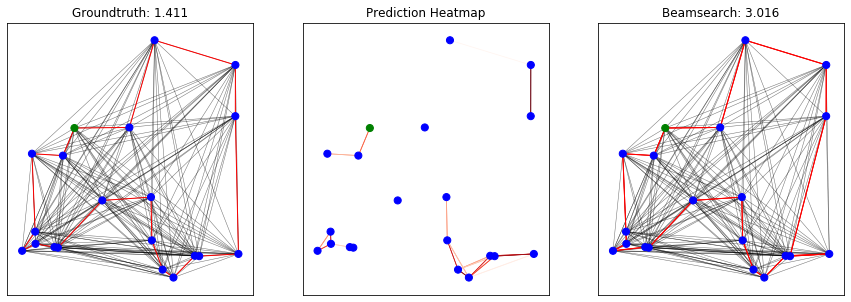

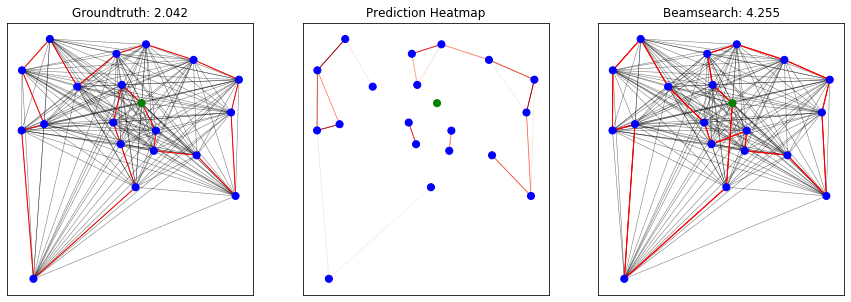

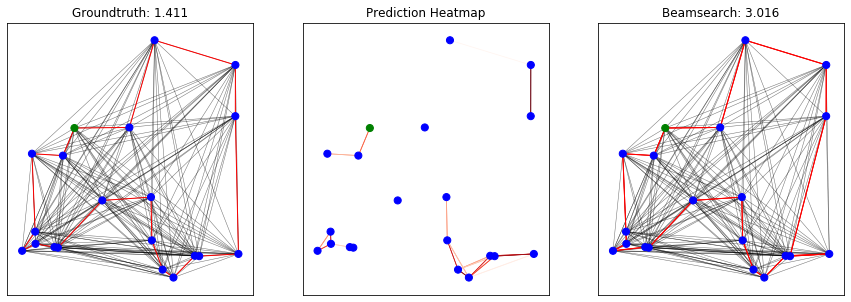

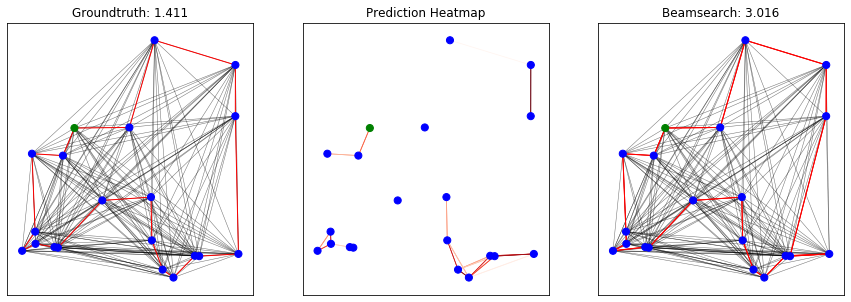

In [207]:
plot_predictions_beamsearch(bg.ndata['coord'].view(2,20,2), th.tensor(np.ones((2,20,20))),
                            x_edges_values, ws, prediction, bs_nodes, num_plots=4)

In [202]:
bg.ndata['coord'].size()

torch.Size([40, 2])

In [0]:

def plot_tsp(p, x_coord, W, W_val, W_target, title="default"):
    """
    Helper function to plot TSP tours.
    
    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W: Edge adjacency matrix
        W_val: Edge values (distance) matrix
        W_target: One-hot matrix with 1s on groundtruth/predicted edges
        title: Title of figure/subplot
    
    Returns:
        p: Updated figure/subplot
    
    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] == 1:
                    pairs.append((r, c))
        return pairs
    
    G = nx.from_numpy_matrix(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    adj_pairs = _edges_to_node_pairs(W)
    target_pairs = _edges_to_node_pairs(W_target)
    colors = ['g'] + ['b'] * (len(x_coord) - 1)  # Green for 0th node, blue for others
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=adj_pairs, alpha=0.3, width=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=target_pairs, alpha=1, width=1, edge_color='r')
    p.set_title(title)
    return p